In [1]:
!pip install -q pycuda

In [2]:
import math
import time
from functools import partial
from IPython.display import display
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from google.colab import files
from pycuda.compiler import SourceModule

In [3]:
!nvidia-smi

Mon Nov 29 14:17:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 149W |     58MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
uploaded_files = files.upload()

print(f"Uploaded {len(uploaded_files)} file(s).")

Saving world.jpg to world (2).jpg
Uploaded 1 file(s).


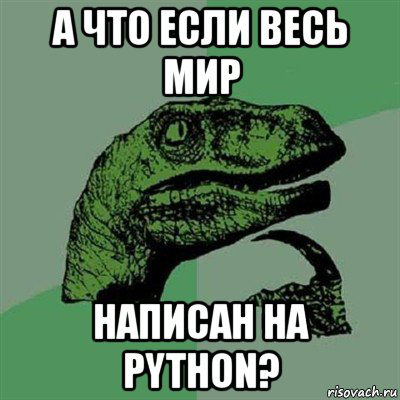

In [5]:
image = Image.open(list(uploaded_files.keys())[0])
display(image)

In [6]:
BLOCK_SIZE = 16

# Размытие

In [7]:
SOURCE_APPLY_TEMPLATE_FILTER = SourceModule("""
__global__ void apply_template_filter(
    unsigned char *image,
    unsigned int height,
    unsigned int width,
    float *kernel,
    unsigned int kernel_size,
    float kernel_sum,
    unsigned char *filtered_image
) {
    unsigned int row = threadIdx.x + blockIdx.x * blockDim.x;
    unsigned int col = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < height && col < width) {
        int kernel_half = kernel_size / 2;
        float blurred_pixel = 0.0;
        for (int i = -kernel_half; i <= kernel_half; ++i) {
            for (int j = -kernel_half; j <= kernel_half; ++j) {
                unsigned int x = max(0, min(height - 1, row + i));
                unsigned int y = max(0, min(width - 1, col + j));

                float weight = kernel[(i + kernel_half) * kernel_size + (j + kernel_half)];
                blurred_pixel += weight * image[x * width + y];
            }
        }
        filtered_image[row * width + col] = static_cast<unsigned char>(blurred_pixel / kernel_sum);
    }
}
""")

In [8]:
def template_filter_cuda(img, kernel_size):
    if kernel_size % 2 != 1:
        raise ValueError(
            "Currently implemented only for square kernels with odd dimensions."
        )

    height, width = img.shape[:2]
    kernel = np.random.random((kernel_size, kernel_size)).astype(np.float32)
    kernel_sum = kernel.sum()

    dim_grid_x = math.ceil(height / BLOCK_SIZE)
    dim_grid_y = math.ceil(width / BLOCK_SIZE)

    apply_template_filter = SOURCE_APPLY_TEMPLATE_FILTER.get_function(
        "apply_template_filter"
    )

    filtered_img = np.empty_like(img)
    for channel_idx in range(img.shape[2]):
        img_channel = img[:, :, channel_idx].copy()
        apply_template_filter(
            cuda.In(img_channel),
            np.uint32(height),
            np.uint32(width),
            cuda.In(kernel),
            np.uint32(kernel_size),
            np.float32(kernel_sum),
            cuda.Out(img_channel),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(dim_grid_x, dim_grid_y)
        )
        filtered_img[:, :, channel_idx] = img_channel

    return filtered_img

In [9]:
def apply_filter(img, filter_fn):
    """Applies filter to image and returns filtered image."""
    img = np.array(img)
    start_time = time.time()
    result = filter_fn(img)
    filtered_img = Image.fromarray(result)
    print(f"Time: {time.time() - start_time:.4f} s.")

    return filtered_img

Time: 0.0083 s.


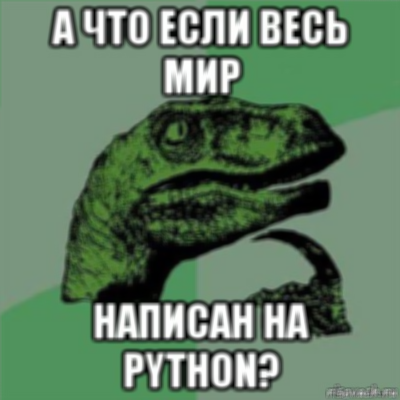

In [10]:
display(apply_filter(image, partial(template_filter_cuda, kernel_size=5)))

Time: 0.0150 s.


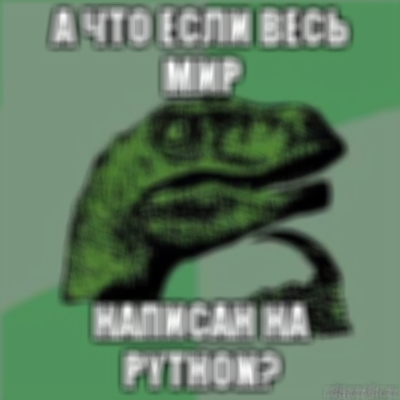

In [11]:
display(apply_filter(image, partial(template_filter_cuda, kernel_size=11)))

# Медианный фильтр

In [12]:
SOURCE_APPLY_MEDIAN_FILTER = SourceModule("""
__global__ void apply_median_filter(
    unsigned char *image,
    unsigned char *filtered_image,
    unsigned int height,
    unsigned int width,
    unsigned int kernel_size
) {
    unsigned int row = threadIdx.x + blockIdx.x * blockDim.x;
    unsigned int col = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < height && col < width) {
        int kernel_half = kernel_size / 2;
        unsigned char* values = new unsigned char[kernel_size * kernel_size];

        // collect window values
        for (int i = -kernel_half; i <= kernel_half; ++i) {
            for (int j = -kernel_half; j <= kernel_half; ++j) {
                unsigned int x = max(0, min(height - 1, row + i));
                unsigned int y = max(0, min(width - 1, col + j));

                values[(i + kernel_half) * kernel_size + (j + kernel_half)] = image[x * width + y];
            }
        }

        // sort window values
        for (unsigned int i = 0; i <= kernel_size * kernel_size / 2; ++i) {
            unsigned int pos = i;
            for (unsigned int j = i + 1; j < kernel_size * kernel_size; ++j) {
                if (values[pos] > values[j]) {
                    pos = j;
                }
            }
            unsigned char tmp = values[pos];
            values[pos] = values[i];
            values[i] = tmp;
        }

        // assign median window value to filtered image pixel
        filtered_image[row * width + col] = values[kernel_size * kernel_size / 2];
        delete[] values;
    }
}
""")

In [13]:
def median_filter_cuda(img, kernel_size):
    if kernel_size % 2 != 1:
        raise ValueError(
            "Currently implemented only for square kernels with odd dimensions."
        )

    height, width = img.shape[:2]

    dim_grid_x = math.ceil(height / BLOCK_SIZE)
    dim_grid_y = math.ceil(width / BLOCK_SIZE)

    apply_median_filter = SOURCE_APPLY_MEDIAN_FILTER.get_function(
        "apply_median_filter"
    )

    filtered_img = np.empty_like(img)
    for channel_idx in range(img.shape[2]):
        img_channel = img[:, :, channel_idx].copy()
        apply_median_filter(
            cuda.In(img_channel),
            cuda.Out(img_channel),
            np.uint32(height),
            np.uint32(width),
            np.uint32(kernel_size),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(dim_grid_x, dim_grid_y)
        )
        filtered_img[:, :, channel_idx] = img_channel

    return filtered_img

Time: 0.6562 s.


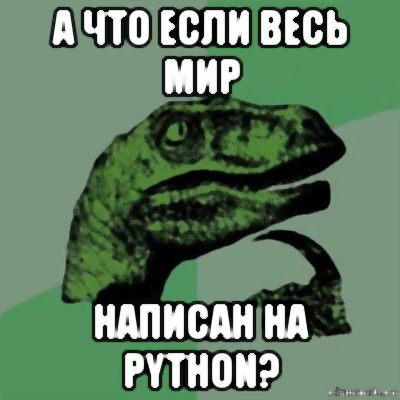

In [14]:
display(apply_filter(image, partial(median_filter_cuda, kernel_size=5)))

Time: 1.5401 s.


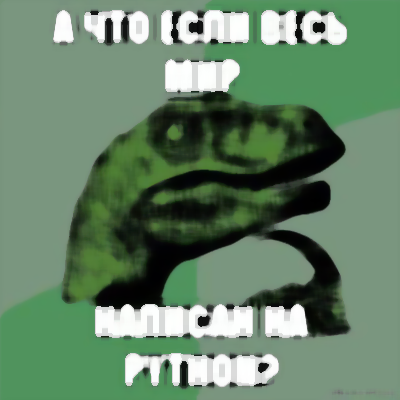

In [15]:
display(apply_filter(image, partial(median_filter_cuda, kernel_size=11)))

# Гистограмма

In [16]:
SOURCE_GET_HISTOGRAM = SourceModule("""
__global__ void get_histogram(
      unsigned char *image,
      unsigned int height,
      unsigned int width,
      unsigned int *bins,
      unsigned int num_bins,
      unsigned int *hist
) {
    unsigned int row = threadIdx.x + blockIdx.x * blockDim.x;
    unsigned int col = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < height && col < width) {
        int value = image[col * width + row];
        for (int i = 0; i < num_bins; ++i) {
            if (value >= bins[i] && value < bins[i + 1]) {
                atomicAdd(&(hist[i]), 1);
            }
        }
    }
  }
  """)

In [17]:
CHANNEL_COLORS = {0: "r", 1: "g", 2: "b"}

In [18]:
def plot_histogram(img, num_bins: int) -> None:
    img = np.array(img)

    height, width = img.shape[:2]
    bins = np.linspace(0, 256, num_bins + 1, dtype=np.uint32)

    dim_grid_x = math.ceil(height / BLOCK_SIZE)
    dim_grid_y = math.ceil(width / BLOCK_SIZE)

    get_histogram = SOURCE_GET_HISTOGRAM.get_function("get_histogram")

    plt.figure(figsize=(16, 8))
    plt.grid()

    for channel_idx in range(img.shape[2]):
        img_channel = img[:, :, channel_idx].copy()
        hist = np.zeros(num_bins, dtype=np.uint32)
        get_histogram(
            cuda.In(img_channel),
            np.uint32(height),
            np.uint32(width),
            cuda.In(bins),
            np.uint32(num_bins),
            cuda.Out(hist),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(dim_grid_x, dim_grid_y)
        )
        plt.plot(
            bins[:-1],
            hist,
            label=f"Channel {channel_idx}",
            color=CHANNEL_COLORS[channel_idx]
        )
    plt.legend(loc="best")

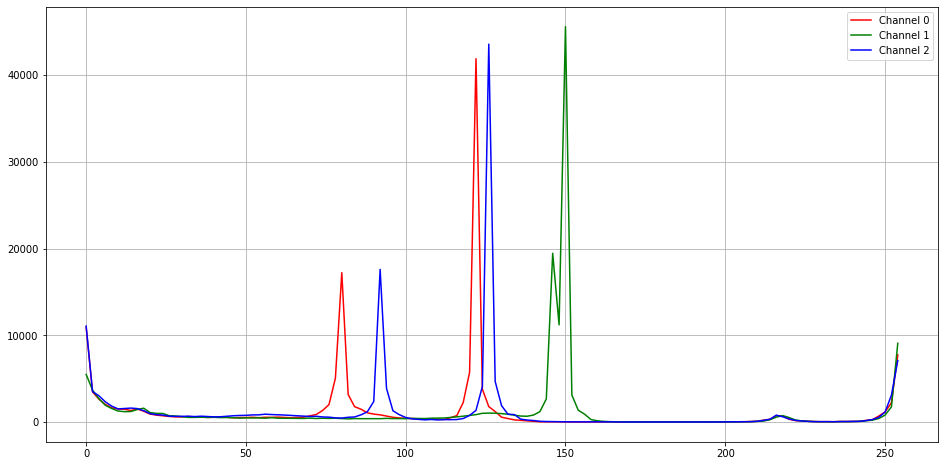

In [19]:
plot_histogram(image, num_bins=128)